# Compilado dos resultados

In [109]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, wilcoxon

import matplotlib.pyplot as plt
import seaborn as sns

from game.core import SurvivalGame, GameConfig
from game.agents import NeuralNetworkAgent

In [110]:
def get_bat_results(num_tests : int = 30, render : bool = False) -> np.ndarray:
    weights = np.load("best_weights.npy")
    
    # Configurações do jogo para o teste
    game_config = GameConfig(render_grid=True)

    total_scores = []

    for i in range(num_tests):
        game = SurvivalGame(config=game_config, render=render)
        agent = NeuralNetworkAgent(weight_vector=weights)
        
        while not game.all_players_dead():
            state = game.get_state(0, include_internals=True)
            action = agent.predict(state)
            
            game.update([action])
            if render:
                game.render_frame()
        
        final_score = game.players[0].score
        total_scores.append(final_score)
    
    return np.array(total_scores)

In [111]:
rule_based_result = [12.69, 16.65, 6.97, 2.79, 15.94, 10.22, 21.90, 4.35, 6.22, 9.95, 19.94, 20.56, 15.74, 17.68, 7.16, 15.68, 2.37, 15.43, 15.13, 22.50, 25.82, 15.85, 17.02, 16.74, 14.69, 11.73, 13.80, 15.13, 12.35, 16.19]
neural_agent_result = [38.32, 54.53, 61.16, 27.55, 16.08, 26.00, 25.33, 18.30, 39.76, 48.17, 44.77, 47.54, 75.43, 23.68, 16.83, 15.81, 67.17, 53.54, 33.59, 49.24, 52.65, 16.35, 44.05, 56.59, 63.23, 43.96, 43.82, 19.19, 28.36, 18.65]
human_result = [27.34, 17.63, 39.33, 17.44, 1.16, 24.04, 29.21, 18.92, 25.71, 20.05, 31.88, 15.39, 22.50, 19.27, 26.33, 23.67, 16.82, 28.45, 12.59, 33.01, 21.74, 14.23, 27.90, 24.80, 11.35, 30.12, 17.08, 22.96, 9.41, 35.22]

In [112]:
rule_based_result = np.array(rule_based_result)
neural_agent_result = np.array(neural_agent_result)
human_result = np.array(human_result)
bat_results = get_bat_results()

In [113]:
print(f"Rule Based   --> Mean: {rule_based_result.mean():.2f} | Std: {rule_based_result.std():.2f}")
print(f"Neural Agent --> Mean: {neural_agent_result.mean():.2f} | Std: {neural_agent_result.std():.2f}")
print(f"Human        --> Mean: {human_result.mean():.2f} | Std: {human_result.std():.2f}")
print(f"Bats         --> Mean: {bat_results.mean():.2f} | Std: {bat_results.std():.2f}")

Rule Based   --> Mean: 13.97 | Std: 5.67
Neural Agent --> Mean: 38.99 | Std: 17.01
Human        --> Mean: 22.19 | Std: 8.11
Bats         --> Mean: 41.43 | Std: 31.14


In [114]:
def bold_values(val, threshold=0.05) -> str:
    """
    Function that applies bold values to the dataframe that are under a threshold.

    Args:
        val: Each value from the dataframe
        threshold (float, optional): Values under this threshold will be transformed to bold. Defaults to 0.05.

    Returns:
        str: Empty or font weight bold
    """
    try:
        num = float(val)
        if num < threshold:
            return "font-weight: bold"
        else:
            return ""
    except (ValueError, TypeError):
        return ""

In [115]:
results = {
    "RB": rule_based_result,
    "NA": neural_agent_result,
    "HR": human_result,
    "BR": bat_results
}

methods = list(results.keys())
n_methods = len(methods)

p_values_df = pd.DataFrame("", index=methods, columns=methods)

for i in range(n_methods):
    for k in range(n_methods):
        
        m_i = methods[i]
        m_k = methods[k]
        
        if i == k:
            p_value = None
        elif i > k:
            t_stat, p_value = ttest_ind(results[m_i], results[m_k])
        else:
            t_stat, p_value = wilcoxon(results[m_i], results[m_k])
        
        p_values_df.loc[m_i, m_k] = f"{p_value:.4f}" if p_value is not None else m_i

p_values_df = p_values_df.style.map(bold_values)
p_values_df

,RB,NA,HR,BR
RB,RB,0.0000,0.0002,0.0000
NA,0.0000,NA,0.0000,0.7151
HR,0.0000,0.0000,HR,0.0699
BR,0.0000,0.7127,0.0021,BR


In [116]:
print(p_values_df.to_latex())

\begin{tabular}{lllll}
 & RB & NA & HR & BR \\
RB & RB & \font-weightbold 0.0000 & \font-weightbold 0.0002 & \font-weightbold 0.0000 \\
NA & \font-weightbold 0.0000 & NA & \font-weightbold 0.0000 & 0.7151 \\
HR & \font-weightbold 0.0000 & \font-weightbold 0.0000 & HR & 0.0699 \\
BR & \font-weightbold 0.0000 & 0.7127 & \font-weightbold 0.0021 & BR \\
\end{tabular}



## Boxplot

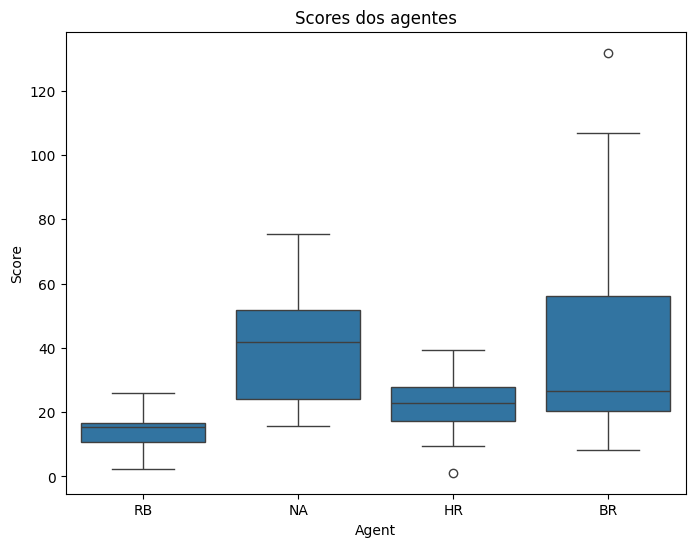

In [117]:
boxplot_df = pd.DataFrame(data=results).melt(var_name="Agent", value_name="Score")

plt.figure(figsize=(8,6))
sns.boxplot(data=boxplot_df, x='Agent', y='Score')
plt.title('Scores dos agentes')
plt.savefig("figs/boxplot.png")
plt.show()